# Sprint 11 - Proyecto

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

---

## Embudo de ventas

Primero, estudia el embudo de ventas. Descubre cómo los usuarios llegan a la etapa de compra. ¿Cuántos usuarios realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

---

## Test A/A/B

Luego, observa los resultados de un test A/A/B . Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios participan en experimentos.

---

## Descripción de los datos

Cada entrada de registro es una acción de usuario o un evento.

- **EventName**: nombre del evento.  
- **DeviceIDHash**: identificador de usuario unívoco.  
- **EventTimestamp**: hora del evento.  
- **ExpId**: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.


## Preparar los datos para el análisis

In [1]:
# Importar librerias 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

In [2]:
# Cargar archivo CSV
logs = pd.read_csv('logs_exp_us.csv',sep='\t')

In [3]:
#Explorar
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
# Convertir nombres de columnas a minúsculas
logs.columns = logs.columns.str.lower()


In [5]:
# Renombrar columnas específicas
logs = logs.rename(columns={
    'deviceidhash': 'device_id',
    'eventtimestamp': 'timestamp',
    'eventname': 'event_name',
    'expid': 'experiment'
})

In [6]:
# Convertir el timestamp (en segundos) a datetime
logs['timestamp'] = pd.to_datetime(logs['timestamp'], unit='s')

In [7]:
# Crear nueva columna solo con la fecha
logs['date'] = logs['timestamp'].dt.date

In [8]:
logs

,event_name,device_id,timestamp,experiment,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


## Estudiar y comprobar los datos

### ¿Cuántos eventos hay en los registros?

In [9]:
# Total de eventos en el dataset
total_events = logs.shape[0]
print(f"tenemos {total_events} eventos en los registros")

tenemos 244126 eventos en los registros


### ¿Cuántos usuarios hay en los registros?

In [10]:
# Total de usuarios únicos 
unique_users = logs['device_id'].nunique()
print(f"tenemos {unique_users} usuarios únicos")

tenemos 7551 usuarios únicos


### ¿Cuál es el promedio de eventos por usuario?

In [11]:
# Promedio de eventos por usuario
avg_events_per_user = total_events / unique_users
print(f"El promedio de eventos por usuario es de {avg_events_per_user:.2f}")

El promedio de eventos por usuario es de 32.33


### ¿Qué periodo de tiempo cubren los datos?

In [12]:
min_date = logs['timestamp'].min()
max_date = logs['timestamp'].max()

print(f"El periodo de datos abarca desde {min_date} hasta {max_date}")

El periodo de datos abarca desde 2019-07-25 04:43:36 hasta 2019-08-07 21:15:17


### ¿Qué periodo representan realmente los datos?

In [13]:
#Contar eventos por día
events_per_day = logs.groupby('date').size()
events_per_day

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
dtype: int64

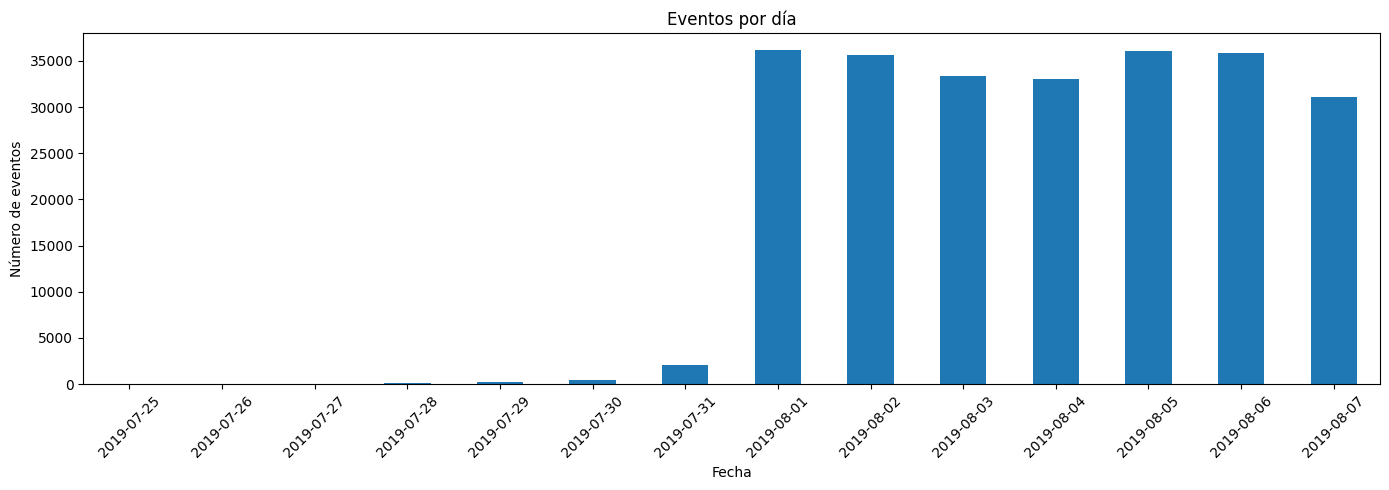

In [14]:
events_per_day.plot(kind='bar', figsize=(14,5))
plt.title('Eventos por día')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El momento en que los datos comienzan a estar completos es el 1 de agosto de 2019. Desde esa fecha en adelante, los volúmenes son estables y altos, lo que indica que el sistema de seguimiento ya estaba funcionando correctamente

### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [15]:
# Filtrar a partir del 1 de agosto de 2019
filtered_logs = logs[logs['timestamp'] >= '2019-08-01']

In [16]:
# Totales después del filtro
total_events_filtered = filtered_logs.shape[0]
unique_users_filtered = filtered_logs['device_id'].nunique()

In [17]:
# Pérdidas en porcentaje
event_loss = 100 * (total_events - total_events_filtered) / total_events
user_loss = 100 * (unique_users - unique_users_filtered) / unique_users
print("No se perdieron muchos eventos ni usuarios al excluir los datos más antiguos.")
print(f"Eventos perdidos: {event_loss:.2f}%")
print(f"Usuarios perdidos: {user_loss:.2f}%")

No se perdieron muchos eventos ni usuarios al excluir los datos más antiguos.
Eventos perdidos: 1.16%
Usuarios perdidos: 0.23%


### Asegúrate de tener usuarios de los tres grupos experimentales.

In [18]:
users_per_group_ = logs.groupby('experiment')['device_id'].nunique()
print(users_per_group_)

experiment
246    2489
247    2520
248    2542
Name: device_id, dtype: int64


In [19]:
users_per_group = filtered_logs.groupby('experiment')['device_id'].nunique()
print(users_per_group)

experiment
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


La pérdida de usuarios por grupo es mínima (solo 5 a 7 usuarios por grupo), lo cual confirma que la gran mayoría de los usuarios activos pertenecen al periodo representativo.

## Estudiar el embudo de eventos

In [20]:
# Contar frecuencia de cada tipo de evento
event_frequencies = filtered_logs['event_name'].value_counts()
event_frequencies

event_name
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: count, dtype: int64

In [21]:
#Contar cuántos usuarios únicos pasaron por cada etapa del embudo.
users_per_event = filtered_logs.groupby('event_name')['device_id'].nunique().sort_values(ascending=False)
users_per_event

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: device_id, dtype: int64

In [22]:
#Proporción de usuarios que realizaron la acción al menos una vez 
users_total = filtered_logs['device_id'].nunique()
users_total

7534

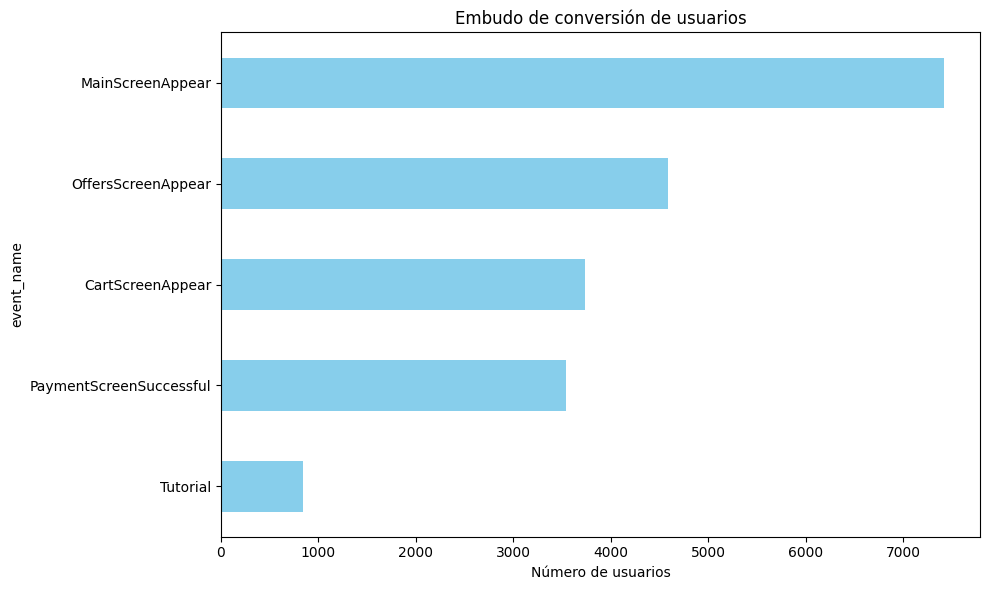

In [23]:
plt.figure(figsize=(10, 6))
users_per_event.plot(kind='barh', color='skyblue')
plt.xlabel("Número de usuarios")
plt.title("Embudo de conversión de usuarios")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

Las acciones parecen seguir una secuencia lógica que representa el embudo principal de ventas, los usuarios abren la aplicación (MainScreenAppear), exploran productos (OffersScreenAppear), revisan el carrito (CartScreenAppear) y finalizan la compra (PaymentScreenSuccessful).

El evento Tutorial, por su baja frecuencia, no forma parte del embudo principal.

In [24]:
users_per_event_ratio = users_per_event / users_total
users_per_event_ratio

event_name
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: device_id, dtype: float64

In [25]:
main = users_per_event['MainScreenAppear']
offers = users_per_event['OffersScreenAppear']
cart = users_per_event['CartScreenAppear']
payment = users_per_event['PaymentScreenSuccessful']

print(f"Tasa Main → Offer: {offers / main:.2%}")
print(f"Tasa Offer → Cart: {cart / offers:.2%}")
print(f"Tasa Cart → Payment: {payment / cart:.2%}")
print(f"Tasa total Main → Payment: {payment / main:.2%}")

Tasa Main → Offer: 61.91%
Tasa Offer → Cart: 81.30%
Tasa Cart → Payment: 94.78%
Tasa total Main → Payment: 47.70%


La mayor pérdida de usuarios ocurre entre la pantalla principal y la pantalla de ofertas, donde aproximadamente el 38% no continúa. Aun así, el 47.7% de los usuarios únicos que comienzan el recorrido llegan hasta completar el pago.

## Estudiar los resultados del experimento

In [26]:
users_per_group

experiment
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

In [27]:
def test_event_proportion(event, group1, group2):
    group_data = filtered_logs[
        (filtered_logs['event_name'] == event) & 
        (filtered_logs['experiment'].isin([group1, group2]))
    ]
    
    users_group1 = group_data[group_data['experiment'] == group1]['device_id'].nunique()
    total_group1 = filtered_logs[filtered_logs['experiment'] == group1]['device_id'].nunique()
    
    users_group2 = group_data[group_data['experiment'] == group2]['device_id'].nunique()
    total_group2 = filtered_logs[filtered_logs['experiment'] == group2]['device_id'].nunique()
    
    counts = [users_group1, users_group2]
    nobs = [total_group1, total_group2]
    
    stat, pval = proportions_ztest(count=counts, nobs=nobs)
    
    print(f"Evento: {event}")
    print(f"Grupo {group1}: {users_group1}/{total_group1} → {users_group1/total_group1:.2%}")
    print(f"Grupo {group2}: {users_group2}/{total_group2} → {users_group2/total_group2:.2%}")
    print(f"Estadístico z: {stat:.4f}, Valor p: {pval:.4f}")

In [28]:
test_event_proportion('MainScreenAppear', 246, 247)

Evento: MainScreenAppear
Grupo 246: 2450/2484 → 98.63%
Grupo 247: 2476/2513 → 98.53%
Estadístico z: 0.3093, Valor p: 0.7571


In [29]:
test_event_proportion('PaymentScreenSuccessful', 246, 247)

Evento: PaymentScreenSuccessful
Grupo 246: 1200/2484 → 48.31%
Grupo 247: 1158/2513 → 46.08%
Estadístico z: 1.5780, Valor p: 0.1146


In [30]:
test_event_proportion('CartScreenAppear', 246, 247)

Evento: CartScreenAppear
Grupo 246: 1266/2484 → 50.97%
Grupo 247: 1238/2513 → 49.26%
Estadístico z: 1.2034, Valor p: 0.2288


In [31]:
test_event_proportion('OffersScreenAppear', 246, 247)

Evento: OffersScreenAppear
Grupo 246: 1542/2484 → 62.08%
Grupo 247: 1520/2513 → 60.49%
Estadístico z: 1.1550, Valor p: 0.2481


 los dos grupos de control (246 y 247) se comportaron de forma estadísticamente similar, lo que valida que la asignación aleatoria de usuarios fue adecuada

In [32]:
from statsmodels.stats.proportion import proportions_ztest

def test_experiment_vs_control(event_name):
    # Usuarios en grupo 248 que hicieron el evento
    users_test = filtered_logs[
        (filtered_logs['experiment'] == 248) &
        (filtered_logs['event_name'] == event_name)
    ]['device_id'].nunique()

    total_test = filtered_logs[filtered_logs['experiment'] == 248]['device_id'].nunique()

    # Usuarios en grupo 246 y 247 combinados que hicieron el evento
    users_control = filtered_logs[
        (filtered_logs['experiment'].isin([246, 247])) &
        (filtered_logs['event_name'] == event_name)
    ]['device_id'].nunique()

    total_control = filtered_logs[filtered_logs['experiment'].isin([246, 247])]['device_id'].nunique()

    # Test estadístico
    count = [users_test, users_control]
    nobs = [total_test, total_control]

    stat, pval = proportions_ztest(count, nobs)

    print(f"Evento: {event_name}")
    print(f"Grupo 248 (prueba): {users_test}/{total_test} → {users_test / total_test:.2%}")
    print(f"Grupo control (246+247): {users_control}/{total_control} → {users_control / total_control:.2%}")
    print(f"Estadístico z: {stat:.4f}, Valor p: {pval:.4f}")
    print("---")


In [33]:
test_experiment_vs_control('MainScreenAppear')
test_experiment_vs_control('OffersScreenAppear')
test_experiment_vs_control('CartScreenAppear')
test_experiment_vs_control('PaymentScreenSuccessful')


Evento: MainScreenAppear
Grupo 248 (prueba): 2493/2537 → 98.27%
Grupo control (246+247): 4926/4997 → 98.58%
Estadístico z: -1.0489, Valor p: 0.2942
---
Evento: OffersScreenAppear
Grupo 248 (prueba): 1531/2537 → 60.35%
Grupo control (246+247): 3062/4997 → 61.28%
Estadístico z: -0.7819, Valor p: 0.4343
---
Evento: CartScreenAppear
Grupo 248 (prueba): 1230/2537 → 48.48%
Grupo control (246+247): 2504/4997 → 50.11%
Estadístico z: -1.3354, Valor p: 0.1818
---
Evento: PaymentScreenSuccessful
Grupo 248 (prueba): 1181/2537 → 46.55%
Grupo control (246+247): 2358/4997 → 47.19%
Estadístico z: -0.5238, Valor p: 0.6004
---


No se encontraron diferencias estadísticamente significativas entre el grupo de prueba (248, con las nuevas fuentes) y los grupos de control combinados (246 + 247).
Esto indica que el cambio en las fuentes no afectó negativamente el comportamiento de los usuarios, al menos en las métricas clave del embudo.

### Corrección de Bonferroni 

In [34]:
alpha_original = 0.05
num_tests = 8
alpha_bonferroni = alpha_original / num_tests
print(f"Nivel de significancia ajustado (Bonferroni): {alpha_bonferroni:.4f}")

Nivel de significancia ajustado (Bonferroni): 0.0063


En estos casos, es importante controlar el riesgo de obtener falsos positivos por azar. Por ello, se aplicó la corrección de Bonferroni, que ajusta el nivel de significancia dividiendo el valor original (0.05) entre el número de pruebas realizadas. El nuevo umbral ajustado fue de 0.00625. Incluso con este criterio más estricto, ninguno de los resultados se acercó al valor crítico, lo cual refuerza aún más la solidez de las conclusiones obtenidas.

### Conclusiones

Los resultados del experimento indican que el nuevo diseño tipográfico puede implementarse sin riesgo, ya que no afecta negativamente el comportamiento de los usuarios. Sin embargo, tampoco se observó una mejora significativa en ninguna de las métricas clave del embudo de conversión.

Por lo tanto, si el objetivo principal del rediseño es mejorar la estética, estandarizar el estilo visual o alinear la interfaz con lineamientos de marca, su implementación es totalmente válida. En cambio, si se esperaba que este cambio impulsara un aumento en la conversión o en el uso de la aplicación, los datos no ofrecen evidencia suficiente para respaldar tal efecto.